# Done by : Krishna Srujan

# 2002401280333

In [1]:
# Import statements
import os
import random

import gym
import numpy as np
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt

from tqdm import tqdm, trange

from collections import defaultdict

import seaborn as sns

from time import sleep
from IPython.display import clear_output, display

%matplotlib inline
plt.style.use('ggplot')

In [2]:
# Parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (9, 6),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

plt.rcParams.update(params)

# Global Parameters
RANDOM_STATE = 24

alpha = 0.4 #0.85
gamma = 0.95
epsilon = 0.8
epsilon_decay = 0.9

 ## Load Frozen Lake Environment

Fronze Lake is a simple game where Actor is on a frozen lake and need to reach a **Goal** on the frozen lake. Some parts of lake are frozen solid and some parts have holes. If Actor walk into a hole, game over!

Actions: $A$ ={0,1,2,3}

    LEFT: 0
    DOWN = 1
    RIGHT = 2
    UP = 3

Whole lake is a 8 x 8 grid world. 
States $S$ are from 0 to 63

SFFFFFFF       (S: starting point, safe)<br>
FFFFFFFF       (F: frozen surface, safe)<br>
FFFHFFFF       (H: hole, fall to your doom)<br>
FFFFFHFF       (G: goal, where the frisbee is located)<br>
FFFHFFFF<br>
FHHFFFHF<br>
FHFFHFHF<br>
FFFHFFFG <br>

<img src='./images/Frozenlake8x8.png' style='width:400px;'>

In [3]:
# Make the environment based on non-deterministic policy. 
# Standard configuration is loaded
env = gym.make('FrozenLake8x8-v0')
env.seed(RANDOM_STATE)
env.reset()
env.render()


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


## Helper Function
### Feel Free to add modify as per your design

In [4]:
def fn_plot_heatmap(values, opt_policy):
    '''
    Plot value function in on the grid
    Args:
        values : np array of shape (8,8)
        opt_policy: one hot encoded policy, numpy array of shape (64,4) 
    return : None
    '''
    fig, ax = plt.subplots()
    act = [action_mappings[action] for action in np.argmax(opt_policy, axis=1)]
    labels = np.asarray(["{0}\n{1:.3f}".format(a, v)
                          for a, v in zip(act,values.ravel())]).reshape(8,8)

    sns.heatmap(values, annot=labels, fmt="", cmap='RdYlGn', ax=ax)
    plt.show()


def fn_display(opt_policy):
    '''
    Function to visualise how agent behaves under given policy
    Args:
        opt_policy: one hot encoded policy, numpy array of shape (64,4)
    '''
    points = 0
    for i_episode in range(5): # run 10 episodes
        observation = env.reset()
        while True: # run until episode is done
            clear_output(wait=True)
            print ('Episode number:{} Score {}'.format(i_episode, points))
            env.render()
            sleep(0.1)
            action = np.argmax(opt_policy[observation])
            observation, reward, done, info = env.step(action)
            points += reward
            if done:
                break

# Action mappings - Map actions to numbers
'''
    Needed in fn_plot_heatmap
    Note: these mappings are only for ornamental purpose 
    and do not contribute to programming logic 
'''
action_mappings = {
    0: '\u2190' , # Left
    1: '\u2193', # Down
    2: '\u2192', # Right
    3: '\u2191', # Up
}

print (action_mappings)

{0: '←', 1: '↓', 2: '→', 3: '↑'}


In [5]:
'''
    Dry Run of the environment
'''
# Go right once (action = 2), we should go to the right but we did not!
env.reset()
action = 2
observation, reward, done, prob = env.step(action)
env.render()
print (observation, reward, done, prob)

  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
8 0.0 False {'prob': 0.3333333333333333}


## Assignment 2
Code TD Prediction as per following algorithm


<img src='./images/TD_prediction_algorithm.JPG' style='width:600px;'>

Create a policy $\pi$ either random or with any other logic. Provide clear explanation of your policy

In [6]:
def td(env,n_episodes):
    
    # First, we initialize the empty value table as a dictionary for storing the values of each state
    V = defaultdict(float)
    N = defaultdict(int)
   
    for ep in range(n_episodes):
        states = []
        actions = []
        rewards = []
        state = env.reset()
        while True:
            states.append(state)
            
            action  = np.random.choice([0,1,2,3]) # take random action
            
            actions.append(action)
            new_state, reward, done, info = env.step(action)
            
            delta = reward + gamma * V[new_state] - V[state]
            V[state] += alpha * delta
            state = new_state
            
            if done:
                break
    return V              

In [7]:
value = td(env, n_episodes=50000)

In [8]:
keys = sorted(value.keys())
values = [value[i] for i in keys]

In [9]:
values = np.array(values).reshape(8,8)

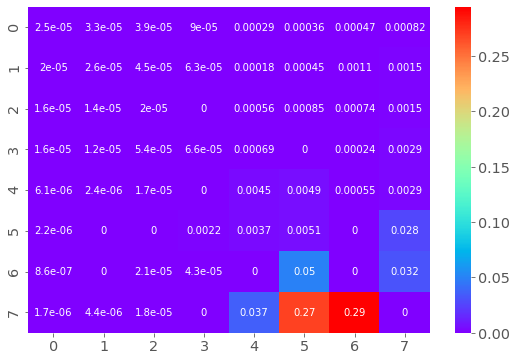

In [10]:
sns.heatmap(values,annot=values,cmap='rainbow')

## Assignment 3
Code  Sarsa (on-policy TD control) for estimating Q = $q_*$


<img src='./images/SARSA.png' style='width:600px;'>

In [11]:
Q = np.zeros((64,4))

In [12]:
def epsilon_greedy_action(state, Q, epsilon):

    values = Q[state,:] # 1*4
    max_value = max(values)
    no_actions = len(values)

    greedy_actions = [a for a in range(no_actions) if values[a] == max_value]
    
    explore = (0.5 < epsilon)
  
    if explore:
        return random.choice([0,1,2,3])
    else:
        return random.choice([a for a in greedy_actions])

In [13]:
def sarsa(Q,env,episodes,epsilon,epsilon_decay):
    
    for episode in range(episodes):

        state = env.reset()
        epsilon *= epsilon_decay # epsilon decays for each state

        action = epsilon_greedy_action(state, Q, epsilon)

        while True:

            new_state, reward, done, info = env.step(action)
            new_action = epsilon_greedy_action(new_state, Q, epsilon)

            delta = reward + gamma * Q[new_state, new_action] - Q[state, action]
            Q[state, action] = Q[state, action] + alpha * delta 

            state, action = new_state, new_action

            if done:
                break
    return Q

In [14]:
final_Q = sarsa(Q,env,100000,epsilon,epsilon_decay)

In [15]:
V = [max(i) for i in final_Q]

In [16]:
V = np.array(V).reshape(8,8) 

In [17]:
V

array([[3.92919382e-03, 4.55496112e-03, 8.35429046e-03, 1.78278232e-02,
        2.72676519e-02, 3.67203952e-02, 4.41280251e-02, 4.81740581e-02],
       [3.86775831e-03, 3.75328377e-03, 3.38875486e-03, 5.16694704e-03,
        7.95701742e-03, 2.59056597e-02, 4.03361895e-02, 5.43605782e-02],
       [3.68462795e-03, 3.21239414e-03, 2.96097473e-03, 0.00000000e+00,
        5.37821725e-03, 7.35140030e-03, 2.50441903e-02, 1.00147372e-01],
       [3.93210955e-03, 3.95572477e-03, 3.26775031e-03, 5.17730151e-04,
        6.36175040e-04, 0.00000000e+00, 4.52439527e-03, 1.70048969e-01],
       [0.00000000e+00, 3.65400630e-06, 0.00000000e+00, 0.00000000e+00,
        2.66961424e-02, 4.95330291e-02, 1.79694443e-02, 1.24761679e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        3.89202095e-02, 1.29127348e-01, 0.00000000e+00, 5.24675553e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.84715418e-01, 0.00000000e+00, 9.

### Evaluation
Your submission should sucessfully plot heatmap for evaluation of the assignment
Use Bellman Optimality Equaltion for State-Value Function
<img src='./images/Bellman_Optimality_Equation.png'>

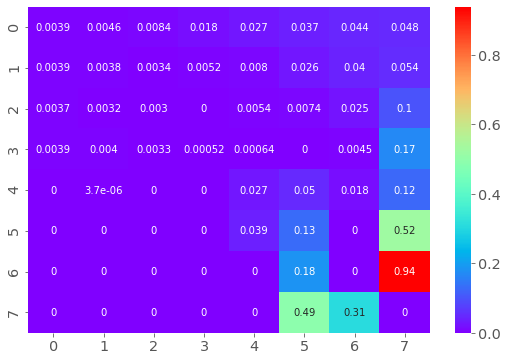

In [18]:
sns.heatmap(V,annot=V,cmap='rainbow')

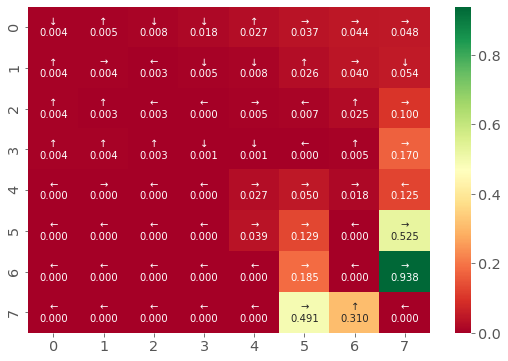

In [19]:
fn_plot_heatmap(V, Q)

In [23]:
fn_display(Q)

Episode number:4 Score 1.0
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


In [22]:
n_iteration = 10
highscore = 0
data_row = []
for n_iter in range(n_iteration):

    points = 0 # keep track of the reward each episode
    data_dict = {}
    for i_episode in range(5): # run 20 episodes
        print ('_'*50)
        observation = env.reset()
        while True: # run until episode is done
            #grid.render()
            action = np.argmax(final_Q[observation])
            observation, reward, done, info = env.step(action)
            points += reward
            if done:
                env.render()
                #print (observation, reward, done, info)

                if points > highscore: # record high score
                    highscore = points
                break
    data_dict['run'] = n_iter
    data_dict['Points']=  points
    data_row.append(data_dict)

__________________________________________________
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
__________________________________________________
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
__________________________________________________
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
__________________________________________________
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
__________________________________________________
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
__________________________________________________
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
__________________________________________________
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
__________________________________________________
  (Down)
SFFFFFFF
FFFFFF